In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.tree import export_graphviz

### Fitting a fixed sqrt curve to saccade data from the paper to get a function for amplitude generation

In [37]:
#equation for the velocity-amplitude curve based on main sequence
a_fs=412.256
b_fs=49.036
c_fs=5.000
popt_fs = tuple([a_fs,b_fs,c_fs])

#equation for vel-amp curve for amplitude <6 degrees
a_exp = 368.93816447
b_exp =0.49166436
c_exp = 1.48726886
popt_exp = tuple([a_exp,b_exp,c_exp])

def func_sigmoid(x,a,b,c):
  return a/(1+(b/x)**c)
def func_fixsqrt(x,a = a_fs,b = b_fs,c = c_fs):
  return a + b*(x-c)**0.5
def func_exp(x, a = a_exp, b = b_exp, c = c_exp):
  return a * (1 - np.exp(-(x-b)/c))

### Laser

Building a saccade target that 
1. Starts either at +7.5/0/-7.5
2. if non 0: Can go to 0/opposite side
3. if 0: can go to either left or right
4. Total of 4 or 5 saccades in the sequence

In [38]:
stim_time = [0,1.259, 2.513, 3.761, 5.009]
stim_time_2 = [0,1.259, 2.513, 3.761, 5.009 , 6.263, 7.511, 8.759, 9.999,10.5]

In [39]:
from itertools import permutations

def generate_sequences(numbers, length, current_sequence=[], results=None):
    if results is None:
        results = []
        
    if len(current_sequence) == length:
        results.append(current_sequence)
        return
    
    last_picked = current_sequence[-1] if current_sequence else None
    
    for num in numbers:
        if num != last_picked:  # Avoid picking the last picked number
            generate_sequences(numbers, length, current_sequence + [num], results)

    return results
# Example usage
amp_options = [0, 7.5, -7.5]
sequences_4 = generate_sequences(amp_options, length=4)
sequences_5 = generate_sequences(amp_options, length=5)
print(len(sequences_4), len(sequences_5))

24 48


In [40]:
def gen_reconstructed_laser(stimulus):
  if len(stimulus) == 4:
    reconstructed_laser = [val for val in stimulus for _ in (0, 1)]
  else:
    reconstructed_laser = [val for val in stimulus[1:] for _ in (0, 1)]
    reconstructed_laser.insert(0,stimulus[0])
  return reconstructed_laser

reconst_laser_4 = gen_reconstructed_laser(sequences_4[6])
reconst_laser_5 = gen_reconstructed_laser(sequences_5[15])

### Target Sequence

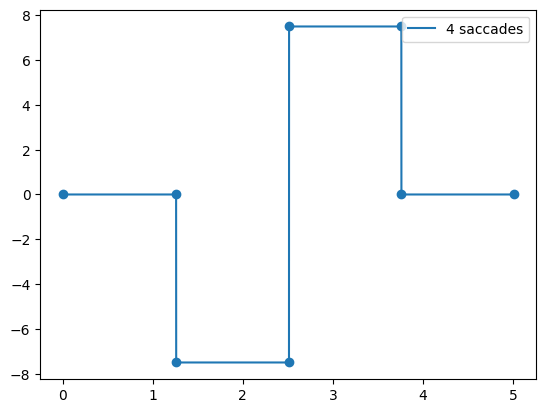

In [41]:
reconstructed_time_4=[0,1.259,1.260,2.513,2.514,3.761,3.762,5.009]
plt.plot(reconstructed_time_4,reconst_laser_4, label="4 saccades")
plt.scatter(reconstructed_time_4,reconst_laser_4)
plt.legend()

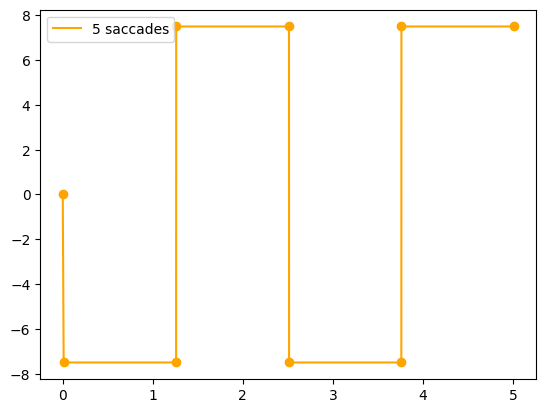

In [42]:
reconstructed_time_5=[0,0.01,1.259,1.260,2.513,2.514,3.761,3.762,5.009]
plt.plot(reconstructed_time_5,reconst_laser_5,label = "5 saccades", color = "orange")
plt.scatter(reconstructed_time_5,reconst_laser_5, color = "orange")
plt.legend()

## Generating the saccades


### Functions to produce latency, velocity and amplitude

In [43]:
#generate the velocity for every saccade
def gen_velocity(amplitude):
  # print("input amp", amplitude)
  amplitude = np.abs(amplitude)
  if amplitude <= 6:
      vel = func_exp(amplitude,a_exp,b_exp,c_exp)
  else:
      vel = func_fixsqrt(amplitude,a_fs,b_fs,c_fs) + np.random.uniform(0,15)*(-1)**np.random.randint(2)
  return vel

#generate the latency for a saccade for each subject
def gen_latency(subject):
    # normal subject latency parameters
    if subject == "N":
      return np.random.uniform(0.1,0.200)
    # abnormal subject latency range
    else:
      return np.random.uniform(0.1,0.2) #for a first pass we are only modeling changes in accuracy


#generate the latency for the correcting saccade
def gen_latency_correcting(subject):
    if subject == "N":
      return np.random.uniform(0.050,0.15)
    else:
      return np.random.uniform(0.050,0.15) #for a first pass we are only modeling changes in accuracy

#generate accuracy for the saccade
def gen_accuracy(subject, condition, sac_seq):
# normal subject accuracy range
  if subject == "N":
      return np.random.uniform(0.9,1.1)
# abnormal subject accuracy range
  else: #abnormal saccade
    if condition == "hyper":
    # initial shift
      if sac_seq == "P":
        return np.random.uniform(1.1,1.5) #what's the upper limit?
      else: #corrective saccade
        return np.random.uniform(1.00,1.1)
    else: #hypometria
    # initial shift
      if sac_seq == "P":
        return np.random.uniform(0.20,0.90)
      else: #corrective saccade
        return np.random.uniform(0.90,1)

### Normal Waveform - Accuracy Only

In [44]:
def gen_normal(stim, subject, condition):
  wave = [stim[0]*0.95, stim[0]*0.95]
  time = [0, 1.26]
  main_seq = []
  last_entry = stim[-1]
  stimulus = stim.copy()
  stimulus.append(last_entry)
  for idx in range(len(stimulus)-1):# Avoids out-of-range issues with stimulus[idx+1]
      # First time point: Start of the saccade (stim start + latency)
      lat = gen_latency("N")
      time.append(time[-1] + lat)  # Appends new latency time
      wave.append(wave[-1])   # Appends current stimulus level
      # print("Step 1:", time[-4:], wave[-4:])

      # Second point: First saccade amplitude
      # amplitude change
      amp = np.random.uniform(0.9,1.1)*(stimulus[idx + 1] - wave[-1])
      wave.append(amp + wave[-1])  # Amplitude added to last wave point
      # generate velocity
      vel = gen_velocity(amp)
      time.append(time[-1] + np.abs(amp / vel))  # Time for saccade based on velocity
      main_seq.append([vel,amp])
      # print("Step 2:", amp, vel, time[-4:], wave[-4:])

      # Hold the saccade
      time.append(time[-1])  # Time after latency correction
      wave.append(wave[-1])  # Holds at current amplitude
      # print("Step 3:", lat2, time[-4:], wave[-4:])

      # Third point: Corrective saccade
      time.append(time[-1])  # Time for corrective saccade
      wave.append(wave[-1])  # New amplitude after corrective saccade
      # print("Step 4:", amp_c, amp, vel_c, time[-1], time[-4:], wave[-4:])

      # Hold the corrective saccade
      if idx >= len(stimulus) - 3:  # Ensure we don’t exceed `stimulus` length
          break
      final_amp = wave[-1]  # Hold at current amplitude for final correction
      time.append(stim_time[idx + 2])  # Appends the next stimulation time
      wave.append(final_amp)  # Append final amplitude
  time.append(5.009)
  wave.append(wave[-1])
    # print("Step 5:", final_amp, stim_time[idx + 2], time[-4:], wave[-4:])
  return time, wave, main_seq

In [45]:
def gen_hyper(stim, subject, condition):
  wave = [stim[0], stim[0]]
  time = [0, 1.26]
  main_seq = []
  last_entry = stim[-1]
  stimulus = stim.copy()
  stimulus.append(last_entry)
  for idx in range(len(stimulus)-1):# Avoids out-of-range issues with stimulus[idx+1]
      last_pos = wave[-1]
      amp_diff = stimulus[idx + 1] - last_pos
      # First time point: Start of the saccade (stim start + latency)
      lat = gen_latency("N")
      time.append(time[-1] + lat)  # Appends new latency time
      wave.append(wave[-1])   # Appends current stimulus level
      # print("Step 1:", time[-4:], wave[-4:])

      # Second point: First saccade amplitude
      # amplitude change
      amp = np.random.uniform(1.1,1.5)*amp_diff
      wave.append(amp + last_pos)
      # Amplitude added to last wave point
      # generate velocity
      vel = gen_velocity(amp)
      time.append(time[-1] + np.abs(amp / vel))  # Time for saccade based on velocity
      main_seq.append([vel,amp])
      # print("Step 2:", amp, vel, time[-4:], wave[-4:])

      # Hold the saccade
      lat2 = gen_latency_correcting(subject, lat)
      time.append(time[-1] + lat2)  # Time after latency correction
      wave.append(wave[-1])  # Holds at current amplitude
      # print("Step 3:", lat2, time[-4:], wave[-4:])

      # Third point: Corrective saccade
      amp_c = np.random.uniform(1.00,1.1) * amp_diff - wave[-1]
      vel_c = gen_velocity(amp_c)
      time.append(time[-1] + np.abs(amp_c / vel_c))  # Time for corrective saccade
      wave.append(amp_c)  # New amplitude after corrective saccade
      main_seq.append([vel_c,amp_c])
      # print("Step 4:", amp_c, amp, vel_c, time[-1], time[-4:], wave[-4:])
      print(wave[-1], amp_c, wave[-1]+amp_c)

      # Hold the corrective saccade
      if idx >= len(stimulus) - 3:  # Ensure we don’t exceed `stimulus` length
          break
      final_amp = wave[-1]  # Hold at current amplitude for final correction
      time.append(stim_time[idx + 2])  # Appends the next stimulation time
      wave.append(final_amp)  # Append final amplitude
  time.append(5.009)
  wave.append(wave[-1])
    # print("Step 5:", final_amp, stim_time[idx + 2], time[-4:], wave[-4:])
  return time, wave, main_seq

In [46]:
def gen_hypo_saccade(amp_diff, curr_wave, curr_time, last_pos):
    time = []
    wave =[]
    main_seq = []
    amp = np.random.uniform(0.20,0.90) * amp_diff
    wave.append(amp + last_pos)
    vel = gen_velocity(amp)
    time.append(curr_time + np.abs(amp / vel))
    main_seq.append([vel, amp])

    # Hold the saccade
    lat2 = gen_latency_correcting("N", lat)
    time.append(time[-1] + lat2)
    wave.append(wave[-1])  # Hold at current amplitude

    # Corrective saccade
    amp_c = np.random.uniform(0.90,1) * amp_diff - (wave[-1]- last_pos)
    vel_c = gen_velocity(amp_c)
    time.append(time[-1] + np.abs(amp_c / vel_c))
    wave.append(wave[-1] + amp_c)
    main_seq.append([vel_c, amp_c])

    return time, wave, main_seq

In [47]:
def gen_hypo_gpt(stim, subject, condition):
    wave = [stim[0], stim[0]]
    time = [0, 1.26]
    main_seq = []
    last_entry = stim[-1]
    stimulus = stim.copy()
    stimulus.append(last_entry)  # Extend stimulus with last value

    stim_time = np.linspace(0, 5, len(stimulus))  # Assuming evenly spaced time points
    
    for idx in range(len(stimulus) - 1):  # Avoid out-of-range issues
        last_pos = wave[-1]
        amp_diff = stimulus[idx + 1] - last_pos

        # First time point: Start of the saccade (stim start + latency)
        lat = gen_latency("N")
        time.append(time[-1] + lat)
        wave.append(wave[-1])  # Hold stimulus level
        
        # First saccade amplitude
        amp = np.random.uniform(0.20,0.90) * amp_diff
        wave.append(amp + last_pos)
        vel = gen_velocity(amp)
        time.append(time[-1] + np.abs(amp / vel))
        main_seq.append([vel, amp])

        # Hold the saccade
        lat2 = gen_latency_correcting(subject, lat)
        time.append(time[-1] + lat2)
        wave.append(wave[-1])  # Hold at current amplitude


        # Corrective saccade
        amp_c = np.random.uniform(0.90,1) * amp_diff - (wave[-1] - last_pos)
        vel_c = gen_velocity(amp_c)
        time.append(time[-1] + np.abs(amp_c / vel_c))
        wave.append(wave[-1] + amp_c)
        main_seq.append([vel_c, amp_c])
        # print(f"Wave: {wave[-1]}, Amp_c: {amp_c}, Final Position: {wave[-1] + amp_c}")

        # Hold the corrective saccade
        if idx + 3 >= len(stim_time):  # Ensure index does not go out of bounds
            break
        
        time.append(stim_time[idx + 2])  
        wave.append(wave[-1])  

    time.append(5.009)
    wave.append(wave[-1])  # Hold at final amplitude

    return time, wave, main_seq


In [48]:
def gen_ind_saccade(amp_diff, curr_wave, curr_time, last_pos, sac_name):
    time = []
    wave =[]
    main_seq = []
    
    if sac_name == 2:
        amp = np.random.uniform(0.20,0.90) * amp_diff
    elif sac_name == 1:
        amp = np.random.uniform(1.2,1.5) * amp_diff
    else:
        amp = np.random.uniform(0.9,1.1) * amp_diff

    wave.append(amp + last_pos)
    vel = gen_velocity(amp)
    time.append(curr_time + np.abs(amp / vel))
    main_seq.append([vel, amp])

    # Hold the saccade
    lat2 = gen_latency_correcting("N")
    time.append(time[-1] + lat2)
    wave.append(wave[-1])  # Hold at current amplitude

    # Corrective saccade
    if sac_name == 2:
        amp_c = np.random.uniform(0.90,1) * amp_diff - (wave[-1]- last_pos)
    elif sac_name == 1:
        amp_c = np.random.uniform(1.1,1.2) * amp_diff - (wave[-1]- last_pos)
    else:
        amp_c = 0
    vel_c = gen_velocity(amp_c) 
    
    time.append(time[-1] + np.abs(amp_c / vel_c))
    wave.append(wave[-1] + amp_c)
    main_seq.append([vel_c, amp_c])

    return time, wave, main_seq

In [49]:
def gen_saccade_seq(sac_num, stim, subject, sac_list):
    
    if sac_num == 4:
        stim_time = [0,1.259, 2.513, 3.761, 5.009]
    else:
        stim_time = [0,0.01, 1.259, 2.513, 3.761, 5.009]
    

    if sac_list[0] == 2:
        multiplier = np.random.uniform(0.7,0.90) 
    elif sac_list[0] == 1:
        multiplier = np.random.uniform(1.1,1.2)
    else:    
        multiplier = np.random.uniform(0.9,1.1)

    first_amp = multiplier * stim[0] if stim[0] != 0 else multiplier
    wave = [first_amp]*2
    time = stim_time[:2].copy()
    main_seq = []
    last_entry = stim[-1]
    stimulus = stim.copy()
    stimulus.append(last_entry)  # Extend stimulus with last value
    
    for idx in range(len(stimulus) - 1):  # Avoid out-of-range issues
        last_pos = wave[-1]
        amp_diff = stimulus[idx + 1] - last_pos

        # First time point: Start of the saccade (stim start + latency)
        lat = gen_latency("N")
        time.append(time[-1] + lat)
        wave.append(wave[-1])  # Hold stimulus level

        #Generating the saccade
        time_next, wave_next, main_seq_next = gen_ind_saccade(amp_diff, wave[-1], time[-1],last_pos, sac_list[idx+1])
        time.extend(time_next)
        wave.extend(wave_next)
        main_seq.extend(main_seq_next)
        # print(time)
        # print(f"Wave: {wave[-1]}, Amp_c: {amp_c}, Final Position: {wave[-1] + amp_c}")

        # Hold the corrective saccade
        if idx + 3 >= len(stim_time):  # Ensure index does not go out of bounds
            break
        time.append(stim_time[idx + 2])  
        wave.append(wave[-1])  

    time.append(5.009)
    wave.append(wave[-1])  # Hold at final amplitude

    return time, wave, main_seq


In [50]:
random_index = np.random.choice(len(sequences_4))
seq = sequences_4[random_index]

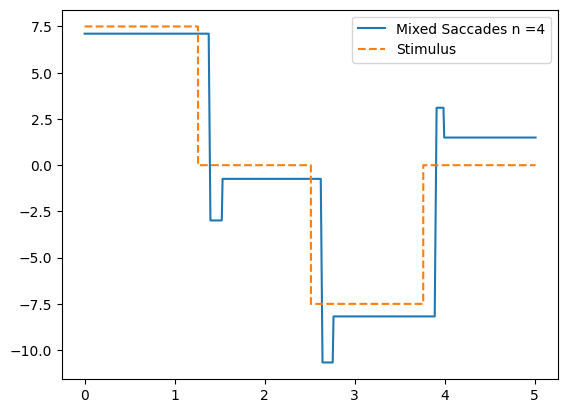

In [51]:
# print(seq)
time_hyper, wave_hyper, main_seq_hyper = gen_saccade_seq(4, seq,"N", [0,1,1,1])
plt.plot(time_hyper, wave_hyper, label="Mixed Saccades n =4")
plt.plot(reconstructed_time_4, gen_reconstructed_laser(seq), "--", label = "Stimulus")
plt.legend()

[7.5, 0, 7.5, 0, 7.5]


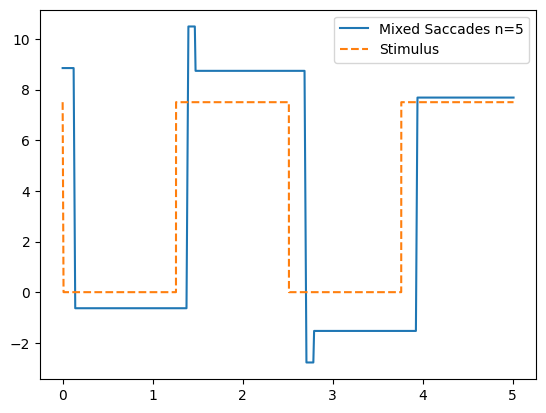

In [52]:
random_index = np.random.choice(len(sequences_5))
seq = sequences_5[random_index]
print(seq)
time_hyper, wave_hyper, main_seq_hyper = gen_saccade_seq(5, seq,"N", [1,0,1,1,0])
plt.plot(time_hyper, wave_hyper, label="Mixed Saccades n=5")
plt.plot(reconstructed_time_5, gen_reconstructed_laser(seq), "--", label = "Stimulus")
plt.legend()

## Waveform -> 176 fps

In [53]:
#MAKING THE SACCADE SEQUENCES
import itertools

numbers = [2,1,0]

# Generate sequences of length 4
sac_list_4 = list(itertools.product(numbers, repeat=4))
sac_list_5 = list(itertools.product(numbers, repeat=5))

# Print some examples
# print("Sequences of length 4:", sac_list_4[:20])  # Print first 5 sequences
print(len(sac_list_4))

81


In [54]:
def remove_common_elements(main_list, remove_list):
    return [item for item in main_list if item not in remove_list]

rem_list_4 = list(set(itertools.permutations([1,1,2,2])))
sac_list_4_truncated = remove_common_elements(sac_list_4, rem_list_4)
print(len(sac_list_4_truncated))

75


In [55]:
def label_sequence(seq):
    for num in numbers:
        if seq.count(num) >= 2:
            return num  # Label as the number that appears 2 or more times
    return -1  # Label as -1 if no number appears twice

# Assign labels
labeled_sequences_4 = [(seq, label_sequence(seq)) for seq in sac_list_4_truncated]
# Count occurrences of each label
label_counts = {0: 0, 1: 0, 2: 0, -1: 0}
for _, label in labeled_sequences_4:
    label_counts[label] += 1

print("Total sequences labeled 0:", label_counts[0])
print("Total sequences labeled 1:", label_counts[1])
print("Total sequences labeled 2:", label_counts[2])


Total sequences labeled 0: 21
Total sequences labeled 1: 27
Total sequences labeled 2: 27


In [56]:
def make_df(time, waveform, samp_freq,i):
    max_t = int(5.009*samp_freq)
    timesteps = np.arange(0,max_t,1)
    wave_1000 = pd.DataFrame(data=timesteps, columns=["timesteps"]).set_index("timesteps")
    wave_df = pd.DataFrame({"timesteps": (np.array(time) * samp_freq).astype(int), f"amplitude_{i}": waveform})
    wave_df.set_index("timesteps", inplace=True)
    wave_1000 = wave_1000.join(wave_df, rsuffix=f"_{i}").interpolate(method='linear', limit_direction='both')
    wave_1000 = wave_1000.join(wave_df,on = "timesteps", rsuffix=f"_{i}")
    return wave_1000

In [57]:
def make_df_with_noise(time, waveform, samp_freq,i, noise_range=(0, 0.2)):
    max_time = int(5.2*samp_freq)
    base_timesteps = np.arange(max_time)

    # Create base DataFrame with regular timesteps
    df_base = pd.DataFrame(
        index=base_timesteps,
        columns=[f'amplitude_{i}'])
    
    # Convert sparse time points to sample indices
    sample_indices = (np.array(time) * samp_freq).astype(int)
    
    # Add waveform data at correct indices
    df_base.loc[sample_indices, f'amplitude_{i}'] = waveform
    
    # Interpolate missing values
    df_interpolated = df_base.interpolate(
        method='linear',
        limit_direction='both',
        axis=0)
    
    # Add noise
    noise_scale = np.random.uniform(*noise_range)
    noise = np.random.normal(
        loc=0,
        scale=noise_scale,
        size=len(df_interpolated))
    df_interpolated += noise.reshape(-1, 1)\

    return df_interpolated

In [58]:
# def gen_reconstructed_laser(stimulus):
#   if len(stimulus) == 4:
#     reconstructed_laser = [val for val in stimulus for _ in (0, 1)]
#   else:
#     reconstructed_laser = [val for val in stimulus[1:] for _ in (0, 1)]
#     reconstructed_laser.insert(0,stimulus[0])
#   return reconstructed_laser

# reconst_laser_4 = gen_reconstructed_laser(sequences_4[6])
# reconst_laser_5 = gen_reconstructed_laser(sequences_5[15])

[7.5, -7.5, 0, 7.5]


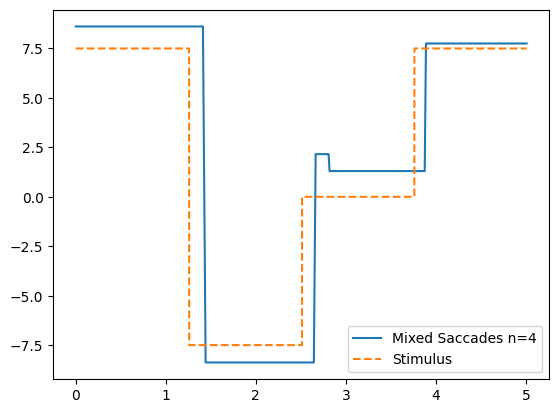

In [59]:
random_index = np.random.choice(len(sequences_4))
seq = sequences_4[random_index]
print(seq)
time_hyper, wave_hyper, main_seq_hyper = gen_saccade_seq(4, seq,"N", [1,0,1,0])
plt.plot(time_hyper, wave_hyper, label="Mixed Saccades n=4")
plt.plot(reconstructed_time_4, gen_reconstructed_laser(seq), "--", label = "Stimulus")
plt.legend()

### Data Generation

In [60]:
from scipy import interpolate

def interpolate_hz(time_sample, wave_sample, frequency):
    """
    Interpolate waveform data to 173 Hz sampling rate
    
    Args:
        time_sample: Original time points
        wave_sample: Original waveform values
    
    Returns:
        new_time: Time points at 173 Hz
        new_wave: Interpolated waveform values
    """
    # Calculate new time points at 173 Hz
    dt = 1/frequency  # time step for 173 Hz
    new_time = np.arange(time_sample[0], time_sample[-1], dt)
    
    # Create interpolation function
    f = interpolate.interp1d(time_sample, wave_sample, kind='linear')
    
    # Generate interpolated waveform
    new_wave = f(new_time)
    
    return new_time, new_wave

In [67]:
import pyarrow as pa
import pyarrow.parquet as pq

def save_waveform_data_parquet(sequences, labeled_sequences, output_path, samples_per_seq=3, noise_range = (0, 0.2)):
    """
    Save waveform data in Parquet format with efficient compression
    """
    data_dict = {
        'time': [],
        'waveform': [],
        'noised_waveform': [],
        'target_sequence': [],
        'saccade_sequence': [],
        'label': [],
        'sample_id': []
    }
    
    for target_seq in sequences:
        for saccade_seq, label in labeled_sequences_4:
            for i in range(samples_per_seq):
                time_sample, wave_sample, _ = gen_saccade_seq(
                    4, target_seq, "N", saccade_seq
                )

                time_173hz, wave_173hz = interpolate_hz(time_sample, wave_sample, 60)
                noise_scale = np.random.uniform(*noise_range)
                noisy_wave = wave_173hz + np.random.normal(loc=0, scale=noise_scale, size=len(wave_173hz))

                data_dict['time'].append(time_173hz)
                data_dict['waveform'].append(wave_173hz)
                data_dict['noised_waveform'].append(noisy_wave)
                data_dict['target_sequence'].append(str(target_seq))
                data_dict['saccade_sequence'].append(str(saccade_seq))
                data_dict['label'].append(label)
                data_dict['sample_id'].append(i)
    
    table = pa.Table.from_pydict(data_dict)
    pq.write_table(table, output_path, compression='snappy')

In [68]:
save_waveform_data_parquet(sequences_4, labeled_sequences_4, './waveform_model/waveform_data_4_full_noised_freq_6.parquet', 3, (0,0.2))

In [69]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq


,time,waveform,noised_waveform,target_sequence,saccade_sequence,label,sample_id
0,"[0.0, 0.016666666666666666, 0.0333333333333333...","[0.7912603264854341, 0.7912603264854341, 0.791...","[0.7660724548111477, 0.7819213289181295, 0.765...","[0, 7.5, 0, 7.5]","(2, 2, 2, 2)",2,0
1,"[0.0, 0.016666666666666666, 0.0333333333333333...","[0.7273065874473159, 0.7273065874473159, 0.727...","[0.373891241130972, 0.9496454653685421, 0.5741...","[0, 7.5, 0, 7.5]","(2, 2, 2, 2)",2,1
2,"[0.0, 0.016666666666666666, 0.0333333333333333...","[0.8002874806650054, 0.8002874806650054, 0.800...","[0.8279722026977411, 0.7965195873400737, 0.919...","[0, 7.5, 0, 7.5]","(2, 2, 2, 2)",2,2
3,"[0.0, 0.016666666666666666, 0.0333333333333333...","[0.8171586569671566, 0.8171586569671566, 0.817...","[0.8672340288849707, 0.6936828397816378, 0.862...","[0, 7.5, 0, 7.5]","(2, 2, 2, 1)",2,0
4,"[0.0, 0.016666666666666666, 0.0333333333333333...","[0.782203742695608, 0.782203742695608, 0.78220...","[0.7832857576528922, 0.7796940463997961, 0.781...","[0, 7.5, 0, 7.5]","(2, 2, 2, 1)",2,1


In [70]:
len(noised_waveform_data_4_df["noised_waveform"].iloc[0])

301

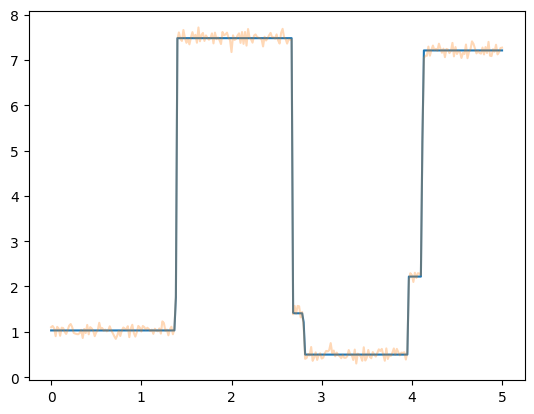

In [71]:
plt.plot(noised_waveform_data_4_df['time'][200], noised_waveform_data_4_df['waveform'][200])
plt.plot(noised_waveform_data_4_df['time'][200], noised_waveform_data_4_df['noised_waveform'][200], alpha=0.3)

## tensorflow

In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()
print(tf.sysconfig.get_build_info())

2025-03-10 10:50:57.028881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741618258.762732  306961 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741618259.228130  306961 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 10:51:03.621742: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


OrderedDict({'cpu_compiler': '/usr/lib/llvm-18/bin/clang', 'cuda_compute_capabilities': ['sm_60', 'sm_70', 'sm_80', 'sm_89', 'compute_90'], 'cuda_version': '12.5.1', 'cudnn_version': '9', 'is_cuda_build': True, 'is_rocm_build': False, 'is_tensorrt_build': False})


In [ ]:
# %pip install --upgrade numpy tensorflow
# import tensorflow as tf
# tf.config.set_visible_devices([], 'GPU')
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [ ]:
x_list = noised_waveform_data_4_df.noised_waveform 
X = pd.DataFrame(x_list.to_list())
y_list = noised_waveform_data_4_df.label
Y = to_categorical(y_list)
X = X.values.reshape((X.shape[0], X.shape[1], 1))
X.shape, Y.shape

((5400, 867, 1), (5400, 3))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42,stratify = Y)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (3780, 867, 1), y_train shape: (3780, 3)
X_test shape: (1620, 867, 1), y_test shape: (1620, 3)


Build model

In [ ]:
# Define the 1D CNN Model
model = Sequential()

# Add 3 convolutional layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(301,1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

# Output layer with 3 classes
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    # callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Save Model

In [ ]:
model.save('waveform_full_noised_model_.keras')

Confusion Matrix

In [ ]:
# Extract the training and validation accuracy and loss from the history object
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Plot the loss curves
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='red')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy', color='blue')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy', color='red')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
if y_test.ndim == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### patient data

In [ ]:
from scipy import interpolate

def interpolate_hz(time_sample, wave_sample, frequency):
    """
    Interpolate waveform data to 173 Hz sampling rate
    
    Args:
        time_sample: Original time points
        wave_sample: Original waveform values
    
    Returns:
        new_time: Time points at 173 Hz
        new_wave: Interpolated waveform values
    """
    # Calculate new time points at 173 Hz
    dt = 1/frequency  # time step for 173 Hz
    new_time = np.arange(time_sample[0], time_sample[-1], dt)
    
    # Create interpolation function
    f = interpolate.interp1d(time_sample, wave_sample, kind='linear')
    
    # Generate interpolated waveform
    new_wave = f(new_time)
    
    return new_time, new_wave

In [ ]:
# main_dir = './waveform_model/labelled_data'
# for f in os.listdir(main_dir)[:10]:
#     fname = os.path.join(main_dir,f)
#     df = pd.read_csv(fname, header=0)
#     tdiff = df["time_step"].iloc[0]-df["time_step"].iloc[-1]
#     freq = len(df)/tdiff
#     print("freq:",freq)

freq: -6.023166060374771e-06
freq: -6.016185826022615e-06
freq: -6.0231643673772086e-06
freq: -6.016193306226907e-06
freq: -6.0231719858737345e-06
freq: -6.016188962880214e-06
freq: -6.0231727114458375e-06
freq: -6.023171139373169e-06
freq: -6.0231718649450675e-06
freq: -6.009225001669062e-06


In [ ]:
import pyarrow as pa
import pyarrow.parquet as pq
import csv

def save_patient_data_parquet(test_data_path, output_path):
    """
    Save waveform data in Parquet format with efficient compression
    """
    data_dict = {
        'time_step': [],
        'stimulus': [],
        'waveform': [],
        'label': [],
        'sample_id':[]
    }
    for file in os.listdir(test_data_path):
        dir_name = os.path.join(test_data_path, file)
        c1 = []
        c2 = []
        c3 = []
        # print(file)
        fname = file.split('_')
        label = fname[-1].replace('.csv', '')          
        label_idx = {"normal": 0, "hyper": 1, "hypo": 2}[label]
        with open(dir_name, 'r') as f:
            reader = csv.reader(f, delimiter=',')
            header = next(reader, None)
            for row in reader:
                c1.append(float(row[0]))
                c2.append(float(row[1]))
                c3.append(float(row[2]))
            
        c1.append(c1[-1])
        c2.append(c2[-1])
        c3.append(c3[-1])

        data_dict['time_step'].append(c1[:301])
        data_dict['stimulus'].append(c2[:301])
        data_dict['waveform'].append(c3[:301])
        data_dict['label'].append(label_idx)
        data_dict['sample_id'].append(f'{fname[0]}_{fname[1]}')
    
    table = pa.Table.from_pydict(data_dict)
    pq.write_table(table, output_path, compression='snappy')

save_patient_data_parquet('./waveform_model/labelled_data', './waveform_model//patient_data_len_301.parquet')

In [120]:
patient_data = pq.read_table('./waveform_model/labelled_data/patient_data_len_301.parquet')
patient_data_df = patient_data.to_pandas()
patient_data_df.head()

,time_step,stimulus,waveform,label,sample_id
0,"[379912444.0, 380085808.0, 380259165.0, 380432...","[7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[9.0073499408603, 8.97694682659295, 9.02456875...",1,005ffe80-e748-446c-aadd-8003010a8b2d_1
1,"[430685175.0, 430916307.0, 431089622.0, 431262...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.553386969631542, 0.512155042654665, 0.50304...",1,021960b7-3c30-4b94-9035-31726c62a363_0
2,"[480724013.0, 480897327.0, 481070691.0, 481244...","[7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.06913714477449, 8.0225840915495, 8.03021650...",0,021960b7-3c30-4b94-9035-31726c62a363_1
3,"[284248046.0, 284479179.0, 284652542.0, 284825...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.532891143703556, -0.67635504942753, -0.486...",0,031924ff-ed34-49ed-b3d8-49d126b7635e_0
4,"[334286822.0, 334460185.0, 334633500.0, 334806...","[7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.78208341865952, 6.83307971179946, 6.7924170...",0,031924ff-ed34-49ed-b3d8-49d126b7635e_1


In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

x_patient_list = patient_data_df.waveform 
X_patient_df = pd.DataFrame(x_patient_list.to_list())
y_patient_list = patient_data_df.label
Y_patient = to_categorical(y_patient_list)
X_patient = X_patient_df.values.reshape((X_patient_df.shape[0], X_patient_df.shape[1], 1))
X_patient.shape, Y_patient.shape
print("Input shape:", X_test.shape)

model_path = './waveform_model/waveform_full_noised_model_2.keras'

# Load model
try:
    model = keras.models.load_model(model_path)
    print("Model loaded successfully")
except Exception as e:
    print(f"Error loading model: {e}")


# Make prediction
y_pred = model.predict(X_test, batch_size=32)
y_pred_classes = np.argmax(y_pred, axis=1)
Y_patient_labels = np.argmax(Y_patient, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(Y_patient_labels, y_pred_classes, 
                            target_names=['Normal', 'Hyper', 'Hypo']))

# Plot confusion matrix
plot_confusion_matrix(Y_patient_labels, y_pred_classes)

# Print some example predictions
print("\nSample Predictions:")
for i in range(min(5, len(Y_patient))):
    true_label = ['Normal', 'Hyper', 'Hypo'][Y_patient_labels[i]]
    pred_label = ['Normal', 'Hyper', 'Hypo'][Y_patient_labels[i]]
    print(f"True: {true_label}, Predicted: {pred_label}")